<a href="https://colab.research.google.com/github/ShahhhVihaan/MoodMirror/blob/main/model-notebooks/moodmirror_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pre-trained Models

## Accessing the data

In [1]:
# mounting drive so we have access to our data stored there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# necessary imports
import os, shutil
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from keras.utils import image_dataset_from_directory

In [3]:
# unzipping the directory in google drive that holds our data
!unzip /content/drive/My\ Drive/train_val_test.zip

Archive:  /content/drive/My Drive/train_val_test.zip
 extracting: test.zip                
 extracting: train.zip               
 extracting: val.zip                 


In [ ]:
# unzipping individual folders
!unzip test.zip
!unzip train.zip
!unzip val.zip

In [5]:
# retrieving the data from the appropriate directories
# we use rgb so that we can use the images with VGG19
train_dir = os.path.join("train")
val_dir = os.path.join("val")
test_dir = os.path.join("test")

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)

Found 44044 files belonging to 7 classes.
Found 12586 files belonging to 7 classes.
Found 6293 files belonging to 7 classes.


# VGG19
This is the first pre-trained model that we use. We will conduct fast feature extraction, fine-tuning, and will show several evaluation techniques.

## Fast feature extraction
Note: Data augmentation was done in preprocessing stage, so we have removed that step from our model. This is true for all later models as well.

In [6]:
# retrieving VGG19
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3)
)

80134624/80134624 [==============================] - 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
import numpy as np

# there are labels associated with each image, which we want to separate from images
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

# this cell took 3 minutes and 16 seconds to run on V100 GPU

In [ ]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(44044, 1, 1, 512)
(12586, 1, 1, 512)
(6293, 1, 1, 512)


In [ ]:
# one-hot encoded labels
print(train_labels[1234])

[0. 0. 0. 0. 1. 0. 0.]


In [ ]:
# we pass everything through the convnet, getting inputs
# we pass everything through our last dense layer
inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# use categorical_crossentropy due to one-hot encoding
model.compile(loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_vgg19.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

# 2 minutes and 23 seconds to run

Epoch 1/20
1377/1377 [==============================] - 10s 5ms/step - loss: 9.2853 - accuracy: 0.2426 - val_loss: 2.0535 - val_accuracy: 0.2834
Epoch 2/20
  45/1377 [..............................] - ETA: 4s - loss: 2.1717 - accuracy: 0.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1377/1377 [==============================] - 5s 4ms/step - loss: 2.1588 - accuracy: 0.2660 - val_loss: 1.9083 - val_accuracy: 0.2886
Epoch 3/20
1377/1377 [==============================] - 7s 5ms/step - loss: 2.1181 - accuracy: 0.2708 - val_loss: 1.9491 - val_accuracy: 0.3242
Epoch 4/20
1377/1377 [==============================] - 6s 5ms/step - loss: 2.1030 - accuracy: 0.2738 - val_loss: 1.9999 - val_accuracy: 0.3012
Epoch 5/20
1377/1377 [==============================] - 6s 4ms/step - loss: 2.0906 - accuracy: 0.2767 - val_loss: 1.8582 - val_accuracy: 0.3053
Epoch 6/20
1377/1377 [==============================] - 7s 5ms/step - loss: 2.0876 - accuracy: 0.2762 - val_loss: 1.9381 - val_accuracy: 0.2675
Epoch 7/20
1377/1377 [==============================] - 6s 4ms/step - loss: 2.0825 - accuracy: 0.2779 - val_loss: 1.8296 - val_accuracy: 0.3112
Epoch 8/20
1377/1377 [==============================] - 7s 5ms/step - loss: 2.0879 - accuracy: 0.2765 - val_loss: 2.0614 - val_accuracy: 0.2411
Epo

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 0s 3ms/step - loss: 2.0429 - accuracy: 0.2686
test acc: 0.26855236291885376


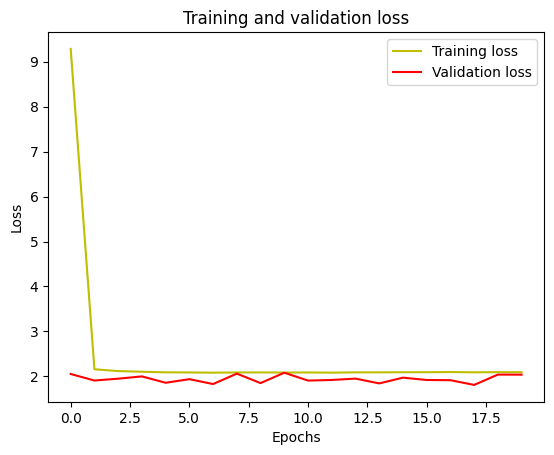

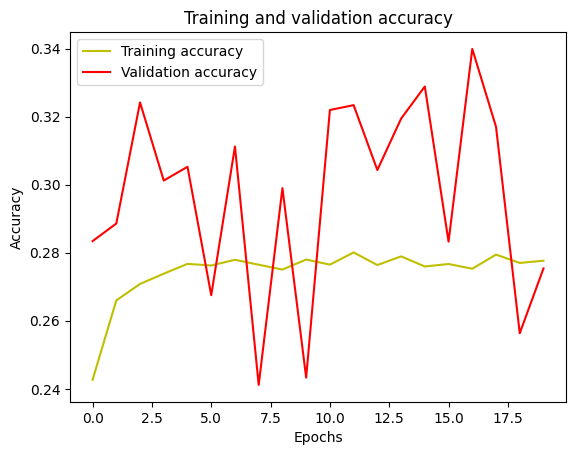

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Fine-tuning pre-trained model (VGG19)

In [ ]:
# 1 Add our custom network on top of an already-trained base network.
# 2 Freeze the base network.
# 3 Train the part we added.

conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False
  )
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation_vgg19.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
1377/1377 [==============================] - 17s 12ms/step - loss: 31.4016 - accuracy: 0.1685 - val_loss: 12.5170 - val_accuracy: 0.2312
Epoch 2/20
1377/1377 [==============================] - 16s 11ms/step - loss: 25.0346 - accuracy: 0.1989 - val_loss: 10.7642 - val_accuracy: 0.2725
Epoch 3/20
1377/1377 [==============================] - 16s 11ms/step - loss: 22.0548 - accuracy: 0.2144 - val_loss: 9.6469 - val_accuracy: 0.2890
Epoch 4/20
1377/1377 [==============================] - 19s 14ms/step - loss: 19.6346 - accuracy: 0.2289 - val_loss: 8.6493 - val_accuracy: 0.3052
Epoch 5/20
1377/1377 [==============================] - 17s 12ms/step - loss: 18.0679 - accuracy: 0.2356 - val_loss: 7.8541 - val_accuracy: 0.3158
Epoch 6/20
1377/1377 [==============================] - 17s 12ms/step - loss: 16.6893 - accuracy: 0.2399 - val_loss: 7.3489 - val_accuracy: 0.3251
Epoch 7/20
1377/1377 [==============================] - 16s 11ms/step - loss: 15.6491 - accuracy: 0.2431 - val_loss:

In [ ]:
# freezing all layers until the fourth from last
# therefore, we are fine-tuning the last three convolutional layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning_vgg19.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
1377/1377 [==============================] - 21s 13ms/step - loss: 2.1189 - accuracy: 0.2046 - val_loss: 1.7814 - val_accuracy: 0.2846
Epoch 2/30
1377/1377 [==============================] - 18s 13ms/step - loss: 1.7369 - accuracy: 0.2930 - val_loss: 1.6553 - val_accuracy: 0.3166
Epoch 3/30
1377/1377 [==============================] - 18s 13ms/step - loss: 1.6245 - accuracy: 0.3650 - val_loss: 1.5924 - val_accuracy: 0.4014
Epoch 4/30
1377/1377 [==============================] - 18s 13ms/step - loss: 1.5502 - accuracy: 0.4130 - val_loss: 1.5379 - val_accuracy: 0.4164
Epoch 5/30
1377/1377 [==============================] - 21s 15ms/step - loss: 1.4842 - accuracy: 0.4307 - val_loss: 1.5114 - val_accuracy: 0.4244
Epoch 6/30
1377/1377 [==============================] - 19s 13ms/step - loss: 1.4249 - accuracy: 0.4476 - val_loss: 1.5645 - val_accuracy: 0.3984
Epoch 7/30
1377/1377 [==============================] - 18s 13ms/step - loss: 1.3694 - accuracy: 0.4613 - val_loss: 1.4812 -

In [ ]:
test_loss, test_acc = keras.models.load_model("fine_tuning_vgg19.h5").evaluate(test_dataset, steps=50)
print('test acc from best model:', test_acc)

50/50 [==============================] - 1s 11ms/step - loss: 2.3074 - accuracy: 0.4806
test acc from best model: 0.4806250035762787


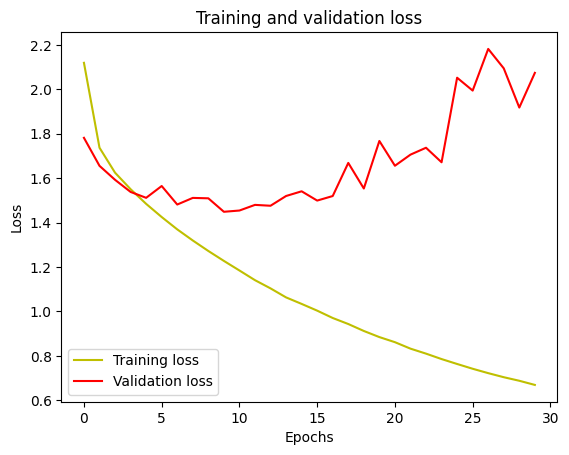

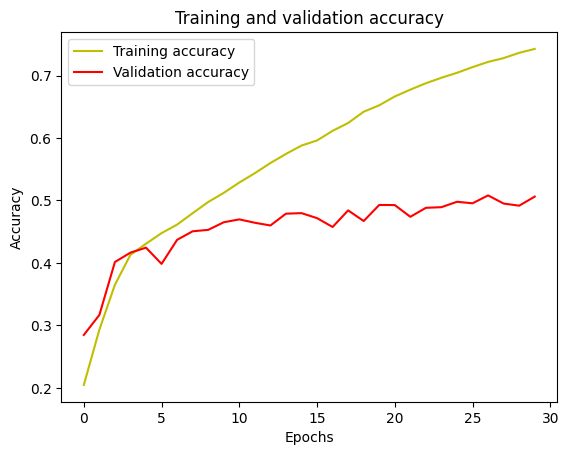

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here, we can see that while our training accuracy is strong, we are overfitting. This can be seen through the significant difference in the accuracy of the training and validation sets as the number of epochs increases. This is further seen by the fact that the evaluation of the model at the end of training yields an accuracy of only 49.75%, even though the validation accuracy is 77.55% after the last epoch.

# Trying a new pretrained model: EfficientNetB0

One of the hallmarks of the EfficientNet models is that they reduce the number of parameters while still achieving high levels of accuracy. Given that our previous model seemed to have overfitting, we are applying data to the new model to see if we can generalize better. If the model seems insufficient, we can try other EfficientNet models (such as EfficientNetB1, 2, 3, etc.) to get something that might be more complex (those models, going up to B7, have more parameters).

Source: https://arxiv.org/abs/1905.11946

In [ ]:
# 1 Add our custom network on top of an already-trained base network.
# 2 Freeze the base network.
# 3 Train the part we added.

conv_base = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 3),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)
conv_base.trainable = False

# no need to preprocess inputs: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/preprocess_input
inputs = keras.Input(shape=(48, 48, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extract_data_aug_efficientnetb0.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20
1377/1377 [==============================] - 36s 21ms/step - loss: 1.8247 - accuracy: 0.2924 - val_loss: 1.6287 - val_accuracy: 0.3798
Epoch 2/20
1377/1377 [==============================] - 31s 22ms/step - loss: 1.6867 - accuracy: 0.3545 - val_loss: 1.5737 - val_accuracy: 0.4029
Epoch 3/20
1377/1377 [==============================] - 25s 18ms/step - loss: 1.6439 - accuracy: 0.3746 - val_loss: 1.5465 - val_accuracy: 0.4168
Epoch 4/20
1377/1377 [==============================] - 29s 21ms/step - loss: 1.6060 - accuracy: 0.3885 - val_loss: 1.5343 - val_accuracy: 0.4219
Epoch 5/20
1377/1377 [==============================] - 26s 19ms/step - loss: 1.5851 - accuracy: 0.3957 - val_loss: 1.5128 - val_accuracy: 0.4299
Epoch 6/20
1377/1377 [==============================] - 27s 19ms/step - loss: 1.5659 - accuracy: 0.4065 - val_loss: 1.5045 - val_accuracy: 0.4348
Epoch 7/20
1377/1377 [==============================] - 27s

In [ ]:
# unfreezing last three convolutional layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning_efficientnetb0.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
1377/1377 [==============================] - 38s 21ms/step - loss: 2.0435 - accuracy: 0.3918 - val_loss: 1.7125 - val_accuracy: 0.4355
Epoch 2/30
1377/1377 [==============================] - 29s 21ms/step - loss: 1.9033 - accuracy: 0.3995 - val_loss: 1.6447 - val_accuracy: 0.4407
Epoch 3/30
1377/1377 [==============================] - 28s 21ms/step - loss: 1.8318 - accuracy: 0.4058 - val_loss: 1.6025 - val_accuracy: 0.4461
Epoch 4/30
1377/1377 [==============================] - 27s 20ms/step - loss: 1.7728 - accuracy: 0.4115 - val_loss: 1.5732 - val_accuracy: 0.4495
Epoch 5/30
1377/1377 [==============================] - 28s 20ms/step - loss: 1.7379 - accuracy: 0.4142 - val_loss: 1.5500 - val_accuracy: 0.4522
Epoch 6/30
1377/1377 [==============================] - 29s 21ms/step - loss: 1.6973 - accuracy: 0.4205 - val_loss: 1.5310 - val_accuracy: 0.4564
Epoch 7/30
1377/1377 [==============================] - 27s 20ms/step - loss: 1.6658 - accuracy: 0.4266 - val_loss: 1.5126 -

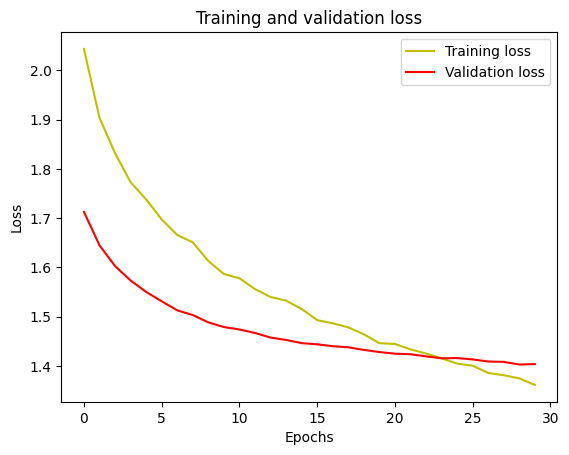

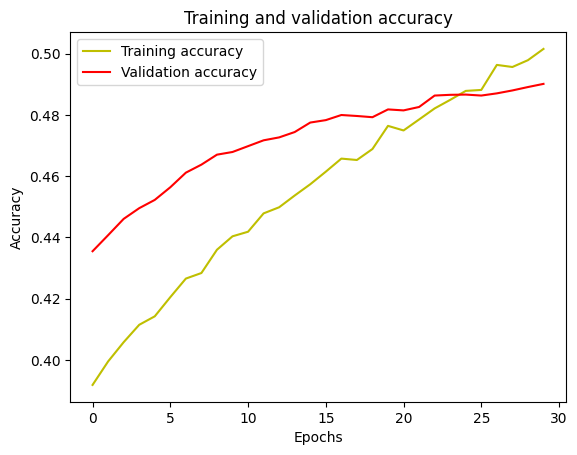

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = keras.models.load_model("fine_tuning_efficientnetb0.h5").evaluate(test_dataset, steps=50)
print('test acc from best model:', test_acc)

50/50 [==============================] - 2s 14ms/step - loss: 1.4193 - accuracy: 0.4919
test acc from best model: 0.4918749928474426


# EfficientNetB5

In [ ]:
conv_base = keras.applications.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 3),
    classes=7,
    classifier_activation="softmax",
)
conv_base.trainable = False

inputs = keras.Input(shape=(48, 48, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extract_data_aug_efficientnetb5.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

115263384/115263384 [==============================] - 1s 0us/step
Epoch 1/25
1377/1377 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.2327

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1377/1377 [==============================] - 75s 39ms/step - loss: 1.9075 - accuracy: 0.2327 - val_loss: 1.8042 - val_accuracy: 0.3014
Epoch 2/25
1377/1377 [==============================] - 47s 34ms/step - loss: 1.8167 - accuracy: 0.2819 - val_loss: 1.7279 - val_accuracy: 0.3341
Epoch 3/25
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7778 - accuracy: 0.3035 - val_loss: 1.7225 - val_accuracy: 0.3398
Epoch 4/25
1377/1377 [==============================] - 47s 34ms/step - loss: 1.7555 - accuracy: 0.3146 - val_loss: 1.7103 - val_accuracy: 0.3295
Epoch 5/25
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7441 - accuracy: 0.3219 - val_loss: 1.6877 - val_accuracy: 0.3515
Epoch 6/25
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7310 - accuracy: 0.3291 - val_loss: 1.6839 - val_accuracy: 0.3584
Epoch 7/25
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7180 - accuracy: 0.3339 - val_loss: 1.6718 - val_accura

In [ ]:
# unfreezing three convolutional layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning_efficientnetb5.h5",
    save_best_only=True,
    monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
1377/1377 [==============================] - 70s 38ms/step - loss: 1.9530 - accuracy: 0.3400 - val_loss: 1.6400 - val_accuracy: 0.4012
Epoch 2/50
1377/1377 [==============================] - 48s 35ms/step - loss: 1.8175 - accuracy: 0.3473 - val_loss: 1.6092 - val_accuracy: 0.4029
Epoch 3/50
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7620 - accuracy: 0.3566 - val_loss: 1.5886 - val_accuracy: 0.4024
Epoch 4/50
1377/1377 [==============================] - 48s 35ms/step - loss: 1.7414 - accuracy: 0.3566 - val_loss: 1.5566 - val_accuracy: 0.4128
Epoch 5/50
1377/1377 [==============================] - 49s 35ms/step - loss: 1.7088 - accuracy: 0.3637 - val_loss: 1.5593 - val_accuracy: 0.4131
Epoch 6/50
1377/1377 [==============================] - 47s 34ms/step - loss: 1.6870 - accuracy: 0.3682 - val_loss: 1.5638 - val_accuracy: 0.4121
Epoch 7/50
1377/1377 [==============================] - 47s 34ms/step - loss: 1.6789 - accuracy: 0.3705 - val_loss: 1.5624 -

In [ ]:
!cp fine_tuning_efficientnetb0.h5 /content/drive/My\ Drive/